In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import numpy as np 
import torchvision.models as models 
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as transforms 
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.metrics import confusion_matrix

from utils import * 
from model import * 

In [2]:
# Ground Truth Dataset 
data = np.load('./CompressedDatasets/cifar/dataset.npz')
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

In [3]:
# def reconstruct_img(x, sigma, Vt) -> torch.Tensor: 
#     x = x @ (torch.diag(sigma) @  Vt)
#     x = x.reshape(32, 32, 3)
#     plt.imshow(x)
#     x = x.permute(2, 0, 1)
#     x = torch.clip(x, 0, 1)
#     return x # [N, 3, 32, 32]

U shape: torch.Size([50000, 3072]), sigma shape: torch.Size([3072]), V shape: torch.Size([3072, 3072])


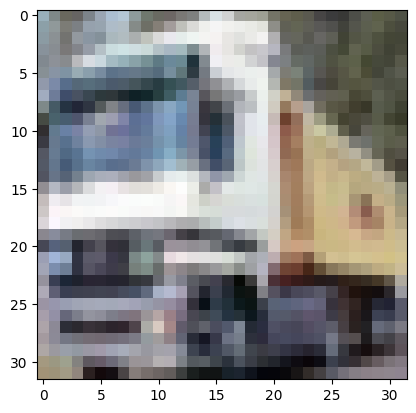

In [4]:
U, sigma, V = prepare_dataset(3072)
print(f"U shape: {U.shape}, sigma shape: {sigma.shape}, V shape: {V.shape}")

reconstructed_img = reconstruct_img(U[1], sigma, V)

reconstructed_img = reconstructed_img.flatten()
U_test = (reconstructed_img @ torch.inverse(V)) @ torch.inverse(torch.diag(sigma))
new_img = U_test @ torch.diag(sigma) @ V
new_img = new_img.reshape(3, 32, 32)
new_img = new_img.permute(1, 2, 0)
plt.imshow(new_img)

In [24]:
def validate(model, test_loader): 
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_test_tensor, y_test_tensor in test_loader:
            y_test_tensor = y_test_tensor.flatten()
            outputs = model(X_test_tensor)
            _, predicted = outputs.max(1)
            correct += (predicted == y_test_tensor).sum().item()  # Accumulate correct predictions
            total += y_test_tensor.size(0)  # Accumulate total samples


    accuracy = 100. * correct / total  # Calculate overall accuracy
    # print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [27]:
def train(model, train_loader, test_loader, optimizer, epochs, criterion, experiment_name = None): 
    train_accuracy = [] 
    val_accuracy = []

    # Training loop
    for epoch in tqdm(range(epochs)):
        model.train()
        running_loss = 0.0
        total = 0
        correct = 0 

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        val_acc = validate(model, test_loader)
        val_accuracy.append(val_acc)

        train_accuracy.append(correct / total)
        # print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {correct / total:.2f}%")

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}, Validation Accuracy: {val_acc}%")

    # Save the model
    if experiment_name is not None:
        torch.save(model.state_dict(), f"./results/cifar-model/{experiment_name}.pth")
        print(f"Model saved as {experiment_name}.pth")
    else: 
        torch.save(model.state_dict(), f"./results/cifar-model/{experiment_name}.pth")
        print(f"Model saved as {experiment_name}.pth")

    return max(val_accuracy)

In [30]:
data = np.load('./CompressedDatasets/cifar/dataset.npz')
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
X_test = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)

singular_values = [] 
accuracies = [] 

for k in range(200, 3072, 200):  
    U, sigma, V = prepare_dataset(k)
    
    # Define training parameters
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleCNN(sigma, V).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    batch_size = 64
    epochs = 10

    # Create DataLoader
    train_dataset = TensorDataset(torch.tensor(U, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(X_test, torch.tensor(y_test, dtype=torch.long))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Train the model
    experiment_name = f"model_{k}"
    acc = train(model, train_loader, test_loader, optimizer, epochs, criterion, experiment_name)
    
    accuracies.append(acc)
    singular_values.append(k)




/var/folders/yp/mbg8sv_n2cz_7gw8tbfw1tvm0000gn/T/ipykernel_4838/4109688549.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(U, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
 10%|█         | 1/10 [00:57<08:37, 57.55s/it]

Epoch 1/10, Loss: 1.4672, Validation Accuracy: 55.22%


 20%|██        | 2/10 [01:55<07:40, 57.61s/it]

Epoch 2/10, Loss: 1.1157, Validation Accuracy: 63.51%


 30%|███       | 3/10 [02:53<06:44, 57.73s/it]

Epoch 3/10, Loss: 0.9633, Validation Accuracy: 66.31%


 40%|████      | 4/10 [03:51<05:47, 57.88s/it]

Epoch 4/10, Loss: 0.8632, Validation Accuracy: 68.37%


 50%|█████     | 5/10 [04:48<04:49, 57.83s/it]

Epoch 5/10, Loss: 0.7840, Validation Accuracy: 70.5%


 60%|██████    | 6/10 [05:56<04:03, 60.98s/it]

Epoch 6/10, Loss: 0.7105, Validation Accuracy: 70.69%


 70%|███████   | 7/10 [07:05<03:10, 63.61s/it]

Epoch 7/10, Loss: 0.6456, Validation Accuracy: 71.28%


 80%|████████  | 8/10 [08:13<02:10, 65.20s/it]

Epoch 8/10, Loss: 0.5891, Validation Accuracy: 70.13%


 90%|█████████ | 9/10 [09:22<01:06, 66.22s/it]

Epoch 9/10, Loss: 0.5288, Validation Accuracy: 71.11%


100%|██████████| 10/10 [10:30<00:00, 63.03s/it]

Epoch 10/10, Loss: 0.4697, Validation Accuracy: 71.2%
Model saved as model_200.pth



 10%|█         | 1/10 [01:07<10:11, 67.94s/it]

Epoch 1/10, Loss: 1.4817, Validation Accuracy: 53.58%


 20%|██        | 2/10 [02:15<09:02, 67.79s/it]

Epoch 2/10, Loss: 1.1238, Validation Accuracy: 61.4%


 30%|███       | 3/10 [03:23<07:54, 67.76s/it]

Epoch 3/10, Loss: 0.9659, Validation Accuracy: 65.32%


 40%|████      | 4/10 [04:30<06:45, 67.53s/it]

Epoch 4/10, Loss: 0.8523, Validation Accuracy: 68.07%


 50%|█████     | 5/10 [05:38<05:38, 67.62s/it]

Epoch 5/10, Loss: 0.7720, Validation Accuracy: 69.23%


 50%|█████     | 5/10 [05:44<05:44, 68.95s/it]


KeyboardInterrupt: 